In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
import cupy as cp
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data_5528.csv')

In [3]:
df = df.loc[:2200]

In [4]:
df_label = pd.read_csv('55285839-9b78-48d8-9f4e-573190ace016_data.csv')

In [5]:
df_label = df_label.loc[:2200]

In [6]:
df['waveform_y']

0       -0.087890625,-0.05859375,-0.0703125,-0.0644531...
1       -0.064453125,-0.08203125,-0.076171875,-0.06445...
2       -0.029296875,-0.10546875,-0.064453125,-0.07031...
3       -0.052734375,-0.0703125,-0.076171875,-0.070312...
4       -0.1640625,0.0234375,0.029296875,-0.1875,-0.16...
                              ...                        
2196    -0.09375,-0.1171875,-0.052734375,-0.10546875,-...
2197    -0.05859375,-0.099609375,-0.08203125,-0.070312...
2198    -0.10546875,-0.064453125,-0.03515625,-0.099609...
2199    -0.076171875,-0.09375,-0.076171875,-0.09960937...
2200    -0.052734375,-0.076171875,-0.08203125,-0.08203...
Name: waveform_y, Length: 2201, dtype: object

In [7]:
def convert_to_float_list(string):
    return [float(x) for x in string.split(',')]

In [8]:
y = df_label['imbalance_health'].values
y = np.where(np.isnan(y), 1, y)
y = np.where(y != 1, 0, 1)

In [9]:
df_wf = pd.DataFrame({
    'waveform_y': df['waveform_y'].apply(convert_to_float_list),
    'label_imbalance': y
})

In [10]:
df_wf[df_wf['label_imbalance'] == 1]

,waveform_y,label_imbalance
0,"[-0.087890625, -0.05859375, -0.0703125, -0.064...",1
1,"[-0.064453125, -0.08203125, -0.076171875, -0.0...",1
2,"[-0.029296875, -0.10546875, -0.064453125, -0.0...",1
3,"[-0.052734375, -0.0703125, -0.076171875, -0.07...",1
4,"[-0.1640625, 0.0234375, 0.029296875, -0.1875, ...",1
...,...,...
2196,"[-0.09375, -0.1171875, -0.052734375, -0.105468...",1
2197,"[-0.05859375, -0.099609375, -0.08203125, -0.07...",1
2198,"[-0.10546875, -0.064453125, -0.03515625, -0.09...",1
2199,"[-0.076171875, -0.09375, -0.076171875, -0.0996...",1


In [11]:
# # 샘플 진동 데이터 생성 (1초 동안 3200개의 샘플)
# t = np.linspace(0, 1, 3200)
# vibration_data = df_wf.loc[0]['waveform_y']

# # 노이즈 추가 (정규분포를 따르는 랜덤 노이즈)
# noise = np.random.normal(0, 0.5, t.shape)
# noisy_vibration_data = vibration_data + noise

# # 모웨이블릿 변환 파라미터 설정
# scales = np.arange(1, 128)
# wavelet = 'cmor1.5-1.0'

# # 원래 데이터에 대해 모웨이블릿 변환
# coefficients_original, frequencies_original = pywt.cwt(vibration_data, scales, wavelet)

# # 노이즈가 추가된 데이터에 대해 모웨이블릿 변환
# coefficients_noisy, frequencies_noisy = pywt.cwt(noisy_vibration_data, scales, wavelet)

# # 시각화 (원래 데이터)
# plt.figure(figsize=(12, 8))

# plt.subplot(2, 1, 1)
# plt.imshow(np.abs(coefficients_original), extent=[0, 1, 1, 128], cmap='jet', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Morlet Wavelet Transform (Original Data)')
# plt.xlabel('Time [s]')
# plt.ylabel('Scale')

# # 시각화 (노이즈가 추가된 데이터)
# plt.subplot(2, 1, 2)
# plt.imshow(np.abs(coefficients_noisy), extent=[0, 1, 1, 128], cmap='jet', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Morlet Wavelet Transform (Noisy Data)')
# plt.xlabel('Time [s]')
# plt.ylabel('Scale')

# plt.tight_layout()
# plt.show()


In [40]:
scales = np.arange(1, 128)
wavelet = 'cmor1.5-1.0'
coefficients_list = []
for i in range(len(df_wf)):
    coefficients_original, frequencies_original = pywt.cwt(df_wf.loc[i]['waveform_y'], scales, wavelet)
    coefficients_list.append(np.abs(coefficients_original))
    if(i % 100 == 0):
        print(i)

NameError: name 'torchwavelet' is not defined

In [28]:
coefficients_list = np.array(coefficients_list)

In [60]:

# CUDA 사용 가능 여부 확인
device = torch.device('cpu')

# 데이터셋 크기
input_dim = 127 * 3200
encoding_dim = 64

# 오토인코더 모델 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 모델 초기화
model = Autoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CWT 변환된 데이터 (모양: 2201, 127, 3200)
X = coefficients_list  # (2201, 127, 3200)
y = df_wf['label_imbalance'].to_numpy()  # 레이블 배열

# 데이터 전처리: (127, 3200)을 (127 * 3200)으로 펼침
X_flattened = X.reshape(X.shape[0], -1)  # (2201, 127*3200)

# 데이터 결합: X와 y 결합
combined_data = np.hstack((X_flattened, y.reshape(-1, 1)))  # (2201, 127*3200+1)

# Train, Validation, Test Set 분리
num_samples = combined_data.shape[0]
train_size = int(num_samples * 0.7)
val_size = int(num_samples * 0.15)

# 훈련 세트와 검증 세트를 무작위로 분리
train_data, temp_data = train_test_split(combined_data, train_size=train_size, random_state=42)

# 남은 데이터를 검증 세트와 테스트 세트로 분리
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# 데이터 로더 준비
X_train_tensor = torch.tensor(train_data[:, :-1], dtype=torch.float32).to(device)  # 훈련 데이터
X_val_tensor = torch.tensor(val_data[:, :-1], dtype=torch.float32).to(device)      # 검증 데이터

train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=32, shuffle=True)

# 학습 루프
epochs = 10
for epoch in range(epochs):
    for data in train_loader:
        # 입력 데이터
        inputs = data.to(device)
        
        # Forward 패스
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete!")

# 검증 세트 평가
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, X_val_tensor)
    print(f'Validation Loss: {val_loss.item():.4f}')


Epoch [1/10], Loss: 0.0017
Epoch [2/10], Loss: 0.0032
Epoch [3/10], Loss: 0.0013
Epoch [4/10], Loss: 0.0008
Epoch [5/10], Loss: 0.0031
Epoch [6/10], Loss: 0.0021
Epoch [7/10], Loss: 0.0032
Epoch [8/10], Loss: 0.0034
Epoch [9/10], Loss: 0.0006
Epoch [10/10], Loss: 0.0017
Training complete!
Validation Loss: 0.0019


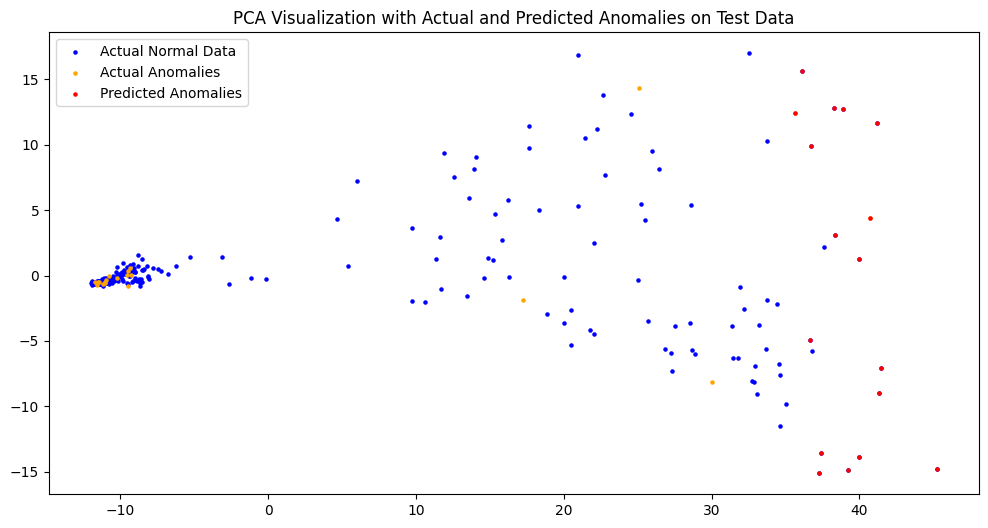

In [63]:
from torch.utils.data import DataLoader, TensorDataset

# 테스트 데이터에서 X와 y 추출
X_test_flattened = test_data[:, :-1]  # 마지막 열 제외 (레이블)
y_test = test_data[:, -1]  # 마지막 열 (레이블)

# 테스트 데이터 텐서로 변환
X_test_tensor = torch.tensor(X_test_flattened, dtype=torch.float32).to(device)

# TensorDataset 및 DataLoader 설정
test_dataset = TensorDataset(X_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델을 평가 모드로 전환
model.eval()

reconstructed_list = []

# 배치 처리로 데이터 재구성
with torch.no_grad():  # 학습이 아니므로 no_grad()로 불필요한 메모리 사용 방지
    for batch in test_dataloader:
        inputs = batch[0].to(device)  # GPU로 전송
        outputs = model(inputs)       # 모델을 사용한 재구성
        reconstructed_list.append(outputs.cpu().numpy())  # 결과를 CPU로 전송 후 리스트에 추가

# 재구성 결과를 하나의 배열로 결합
reconstructed = np.vstack(reconstructed_list)

# 재구성 오차 계산
reconstruction_error = np.mean(np.power(X_test_flattened - reconstructed, 2), axis=1)

# 이상치 탐지 (재구성 오차 기준)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 이상치로 간주
anomalies = reconstruction_error > threshold

# PCA 적용 (2D로 시각화)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_flattened)

# 결과 시각화
plt.figure(figsize=(12, 6))

# 실제 정상 데이터 포인트
plt.scatter(X_test_pca[y_test == 1, 0], X_test_pca[y_test == 1, 1], c='blue', s=5, label='Actual Normal Data')

# 실제 비정상 데이터 포인트
plt.scatter(X_test_pca[y_test == 0, 0], X_test_pca[y_test == 0, 1], c='orange', s=5, label='Actual Anomalies')

# 예측된 이상치 포인트
plt.scatter(X_test_pca[anomalies, 0], X_test_pca[anomalies, 1], c='red', s=5, label='Predicted Anomalies')

plt.title('PCA Visualization with Actual and Predicted Anomalies on Test Data')
plt.legend()
plt.show()